# llc4320 drifters spectra


- Need to check time sampling


In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14)
    w = cluster.scale(jobs=3) # 3 needed for lon/lat binning
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.20:50662 Dashboard: http://10.148.0.20:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## load data

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
#df = p.df['trajectory']

In [5]:
# read raw spectra
df_chunked = p.load_diagnostic('spectra_raw')
df_chunked = df_chunked.persist()
df_chunked.head()

,time,lon,lat,0.0,0.016655100624566273,0.033310201249132546,0.04996530187369882,0.06662040249826509,0.08327550312283136,0.09993060374739764,...,-0.1665510062456627,-0.14989590562109645,-0.13324080499653018,-0.11658570437196392,-0.09993060374739764,-0.08327550312283136,-0.06662040249826509,-0.04996530187369882,-0.033310201249132546,-0.016655100624566273
trajectory,,,,,,,,,,,,,,,,,,,,,
1000038.0,30,-33.676429,-52.594186,0.524538,0.133783,0.111791,0.146400,0.011278,0.165607,0.058685,...,0.018281,0.029967,0.026024,0.083875,0.042077,0.091839,0.063079,0.045470,0.088119,0.339132
1000038.0,60,-29.237674,-50.967788,1.198771,0.324185,0.253451,0.290681,0.034363,0.066021,0.170910,...,0.051048,0.030542,0.003306,0.126455,0.255409,0.046729,0.063594,0.071592,0.159472,0.632436
1000038.0,90,-24.902603,-49.557339,0.364368,0.615906,0.426947,0.081047,0.001642,0.041771,0.066816,...,0.002386,0.019610,0.094394,0.004832,0.225937,0.197885,0.091288,0.035753,0.248429,0.036457
1000038.0,120,-22.193679,-49.064318,0.190423,0.384258,0.273943,0.101859,0.110949,0.041574,0.031536,...,0.011904,0.041910,0.119263,0.080170,0.018886,0.008113,0.042596,0.020105,0.172400,0.034812
1000038.0,150,-17.620525,-49.277763,1.581558,0.534713,0.484444,0.658229,0.156415,0.017785,0.014681,...,0.041796,0.079898,0.102977,0.060744,0.041873,0.340209,0.936775,0.511765,0.009427,0.913730


---
## bin data: latitude

In [7]:
# bin geographically
dl = 1.
lat_bins = np.arange(-60, 60, dl)

df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['time','lon','lat'])
              .reset_index(), 
              id_vars=['lat_cut',], 
              var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

In [8]:
# store diagnostic
p.store_diagnostic('spectra_lat', ds, overwrite=True)

spectra_lat diagnostics stored in /home1/datawork/aponte/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_lat.zarr


In [9]:
# load spectra
ds = p.load_diagnostic('spectra_lat.zarr')

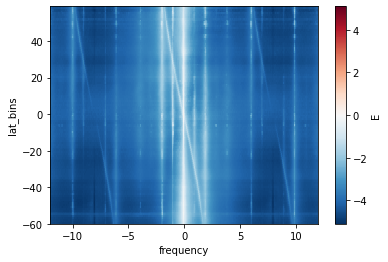

In [10]:
np.log10(ds.E).plot()

---
## bin data: longitude x latitude

In [14]:
# bin geographically
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

df_chunked['lon'] = (df_chunked['lon']+180)%360 - 180

df_chunked['lon_cut'] = df_chunked['lon'].map_partitions(pd.cut, bins=lon_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lon_cut', 'lat_cut']).mean().compute()

In [32]:
#Converting pandas dataframe in xarray dataset:
index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                   E.index.map(lambda v: v[1].mid)
                                  ], 
                                  names=('lon_cut', 'lat_cut'),
                                 )
ds = (pd.melt(E.set_index(index)
              .drop(columns=['time','lon','lat'])
              .reset_index(), id_vars=['lon_cut', 'lat_cut',],
              var_name='frequency',
             )
      .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')
ds

<xarray.Dataset>
Dimensions:    (frequency: 1441, lat_bins: 59, lon_bins: 179)
Coordinates:
  * lon_bins   (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins   (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
  * frequency  (frequency) object '-0.016655100624566273' ... '9.993060374739...
Data variables:
    E          (lon_bins, lat_bins, frequency) float64 0.5614 ... 3.14e-05

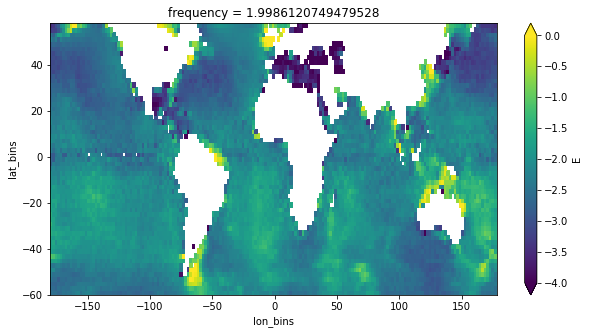

In [47]:
np.log10(ds.E.sel(frequency=2., method='nearest')).plot(x='lon_bins', y='lat_bins', 
                                                        vmin=-4, vmax=0, 
                                                        figsize=(10,5),
                                                       )

## Close cluster

In [48]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
